In [1]:
import numpy as np
import scipy as sp
from tqdm import tqdm
from scipy import stats
from scipy.stats import chi2 

import matplotlib.pyplot as plt

### Q. 2.7.1
model: $t_i = t_0 + s_2 x_i\newline$
noise in first arrival times $\sim \mathcal{N}(0,0.1)$

In [2]:
def getL2Sol(data, G):
    
    """
    Function to calculate least square/maximum likelihood solution
    
    Parameters
    -----------
    data: data (numpy array) # dependent variable only
    G: model matrix (numpy array)
    
    Returns
    --------
    ls_sol: least square solution
    residual: res
    G: model matrix
    
    """

    #-- ML2 Solution ---
    Coeff = np.matmul(np.linalg.inv(np.matmul(np.transpose(G), G)), np.transpose(G))
    ls_sol = np.matmul(Coeff, data)
    
    return ls_sol
    
    
def getResidual(data, sol):
    
    """
    Function to calculate least square residuals
    
    Parameters
    -----------
    data: data (numpy array)
    ls_sol: least square solution (numpy array)
    
    Returns
    --------
    residual (numpy array)
    
    """
    
    return data - np.matmul(G, sol.reshape(len(sol),1)).flatten()
    

In [3]:
mean, sigma = 0, 0.1
data = np.array([[6.0000, 3.4935], [10.1333, 4.2853], [14.2667, 5.1374], [18.4000, 5.8181], \
                    [22.5333, 6.8632], [26.6667, 8.1841]])

nParams = 2
nObs = data.shape[0]

#-- model matrix ---
G = np.ones((nObs, nParams))
G[:,1] = G[:,1] * data[:,0]


#### Part (a)

In [4]:
L2_solution = getL2Sol(data[:,1], G)
print('Least square solution')
print('t0: {}'.format(L2_solution[0]))
print('s2: {}'.format(L2_solution[1]))

Least square solution
t0: 2.032337083707942
s2: 0.22028140303828952


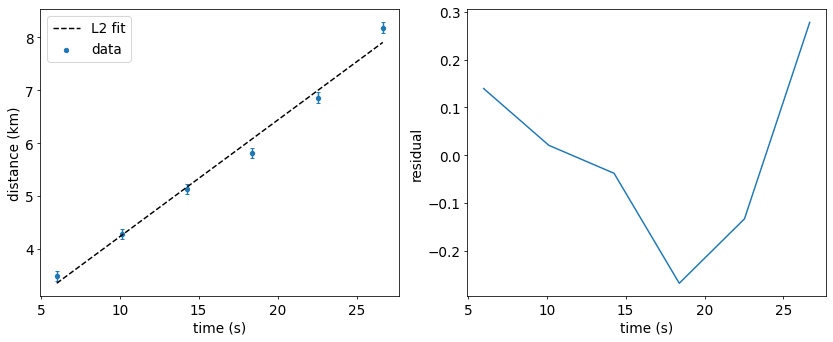

In [5]:
#-- model prediction with ML2 solution ---
model_L2 = L2_solution[0] + L2_solution[1]*data[:,0]

#-- model residual calculation --
L2_residual = getResidual(data[:,1], L2_solution)

#-- plotting the data with model prediction ---
plt.figure(figsize=(12,5), dpi=70)

plt.subplot(121)
plt.scatter(data[:,0], data[:,1], label='data', s=20)
plt.errorbar(data[:,0], data[:,1], yerr = sigma, capsize=2, ls='None')
plt.plot(data[:,0], model_L2, ls='--', c='k', label='L2 fit')
plt.xlabel('time (s)', fontsize=14)
plt.ylabel('distance (km)', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)

plt.subplot(122)
plt.plot(data[:,0], L2_residual)
plt.xlabel('time (s)', fontsize=14)
plt.ylabel('residual', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()

#### Part (b)

In [6]:
#-- covariance matrix and variance array --
CovMat = sigma**2 * np.linalg.inv(np.matmul(np.transpose(G), G))
Var = np.diag(CovMat)

CorrelMat = np.zeros((nParams, nParams))

for i in range(nParams):
    for j in range(nParams):
        CorrelMat[i,j] = CovMat[i,j]/np.sqrt(Var[i]*Var[j])
        
print('Correlation matrix')
print(CorrelMat)

Correlation matrix
[[ 1.         -0.91793986]
 [-0.91793986  1.        ]]


#### Comments
As evident from the correlation matrix above, there is a very high correlation between the interval time $t_0$ and slowness of the lower layer $s_2$, thus implying high statistical dependence on each other. Therefore the error ellipsoids are expected to be inclined in the model space $(t_0, s_2)$. 

#### Part (c)

In [7]:
def contour(CovMat, Deltasq):
    
    """
    Function to generate contour for a given confidence interval
    
    Parameters
    -----------
    CovMat: covariance matrix (numpy array)
    Deltasq: ppf value chi2 distribution for a given percentile
    
    Returns
    --------
    r: contour (xi: r[:,i])
    
    """
    
    theta = np.linspace(0, 2*np.pi, 10000)
    xhat = np.column_stack((np.cos(theta), np.sin(theta)))
    
    CInv = np.linalg.inv(CovMat)
    
    r = np.zeros((N, CovMat.shape[0]))
    
    for i in range(N):
        
        r[i,:] = np.sqrt(Deltasq/(np.matmul(np.matmul(xhat[i,:].reshape(1,2), CInv), 
                                          xhat[i,:].reshape(1,2).T)))*xhat[i,:]
    return r

In [8]:
N = 10000
pcentle = 0.95 # percentile
Deltasq = chi2.ppf(0.95, nParams) # ppf value
vals = contour(CovMat, Deltasq) # contour calculation

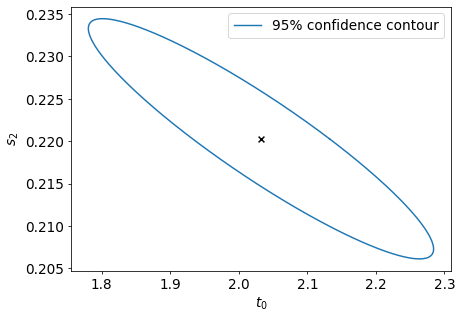

In [9]:
plt.figure(figsize=(7,5), dpi=70)

plt.plot(vals[:,0] + L2_solution[0], vals[:,1] + L2_solution[1], \
                             label='95% confidence contour')
plt.scatter(L2_solution[0], L2_solution[1], marker='x', c='k')
plt.xlabel(r'$t_0$', fontsize=14)
plt.ylabel(r'$s_2$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

#### Part (d)

In [10]:
#-- chisquare statistic ---
chisq_obs = np.sum((data[:,1] - np.matmul(G, L2_solution.reshape(nParams,1)).flatten())**2 / sigma**2)
print('chisq_obs = {}'.format(chisq_obs))
print('p-value: {}'.format(1 - chi2(nObs-nParams).cdf(chisq_obs)))


chisq_obs = 18.75018390401006
p-value: 0.0008799160761213676


#### Part (e)

In [11]:
seed = 0
np.random.seed(seed)

nRealzns = 1000
noise_realzns = mean + sigma*np.random.randn(data.shape[0], nRealzns)
data_realzns = np.zeros((data.shape[0], nRealzns))
chisq = np.zeros(nRealzns)

#-- making different data realizations --
for i in range(nRealzns):
    
    data_realzns[:,i] = model_L2 + noise_realzns[:,i]

#-- calculating chisquare for each realization --    
for j in range(nRealzns):
    
    chisq[j] = np.sum((data_realzns[:,j] - np.matmul(G, \
                        getL2Sol(data_realzns[:,j], G).reshape(nParams,1)).flatten())**2 / sigma**2)
    

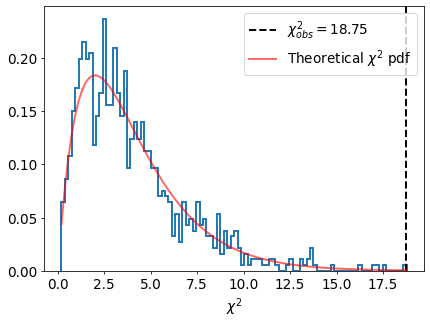

In [12]:
plt.figure(figsize=(7,5), dpi=70)

_, bins, _ = plt.hist(chisq, bins=100, histtype='step', lw=2, density=True);
plt.axvline(x=chisq_obs, ls='--', c='k', lw=2, label=r'$\chi_{obs}^2 = %.2f$'%chisq_obs)
plt.plot(bins, chi2.pdf(bins, nObs-nParams),
               'r-', lw=2, alpha=0.6, label=r'Theoretical $\chi^2$ pdf')

plt.xlabel(r'$\chi^2$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc=1, fontsize=14)
plt.show()

#### Part (f)
No, the p-value and Montel carlo $\chi^2$ distribution ain't consistent with theoretical modeling and the data set. This might probably be due to an outlier which could be the last entry of the data.


#### Part (g)

$$G^T RG\,m = G^{T}R \,\vec d$$

#### Iterative reweighted least square (IRLS) algorithm

We start with $m^{(0)} = m_{L2}$ solution and calculate the corresponding residual vector $r^{(0)} = d - Gm^{(0)}$ to construct the weighting matrix $R$, where $R_{i,i} = \frac{1}{|r_i|}$. We then solve the above equation to obtain a new model $m^{(1)}$ and associated residual vector $r^{(1)}$. The process is repeated until the model and residual vectors converge. A typical rule is to stop the iteration when 

$$\frac{||m^{(k+1)} - m^{(k)}||_{2}}{1+||m^{(k+1)}||_2} < \tau $$

for a specified tolerance $\tau$.

In [13]:
def getL1Sol(data, G, L2_solution, tol):
    
    """
    Function to calculate IRLS/ML1 solution
    
    Parameters
    -----------
    data: data (numpy array)
    G: model matrix (numpy array)
    ls_solution: least square solution for the initialization of iterative procedure
    tol: error tolerance
    
    Returns
    --------
    
    mL1_new: ML1 solution (numpy array)
    
    """
        
    nObs, nParams = G.shape
    
    error = 1
    m_init = L2_solution  # L2 solution as the seed for IRLS procedure

    while(error > tol):

        # cacluate the R matrix
        r_init = data - np.matmul(G, m_init.reshape(nParams,1)).flatten()
        R_init = np.zeros((nObs, nObs))

        for i in range(nObs):

            R_init[i,i] = 1/abs(r_init[i])

        # calculate the coefficient matrix
        Coeff = np.matmul(np.linalg.inv(np.matmul(np.matmul(np.transpose(G), R_init), G)), \
                          np.matmul(np.transpose(G), R_init))

        # new ML1 solution
        mL1_new = np.matmul(Coeff, data)

        # error calculation
        error = np.linalg.norm(mL1_new - m_init) / (1 + np.linalg.norm(mL1_new))

        m_init = mL1_new
        
    return mL1_new

tol = 10**(-5)
L1_solution = getL1Sol(data[:,1], G, L2_solution, tol) # data as t values in this model

print('IRLS/L1 solution')
print('t0: {}'.format(L1_solution[0]))
print('s2: {}\n'.format(L1_solution[1]))

print('L2 solution')
print('t0: {}'.format(L2_solution[0]))
print('s2: {}'.format(L2_solution[1]))

#-- model prediction with ML1 solution ---
model_L1 = L1_solution[0] + L1_solution[1]*data[:,0]

#-- model residual calculation --
L1_residual = getResidual(data[:,1], L1_solution)


IRLS/L1 solution
t0: 2.178635962094999
s2: 0.2078951612904837

L2 solution
t0: 2.032337083707942
s2: 0.22028140303828952


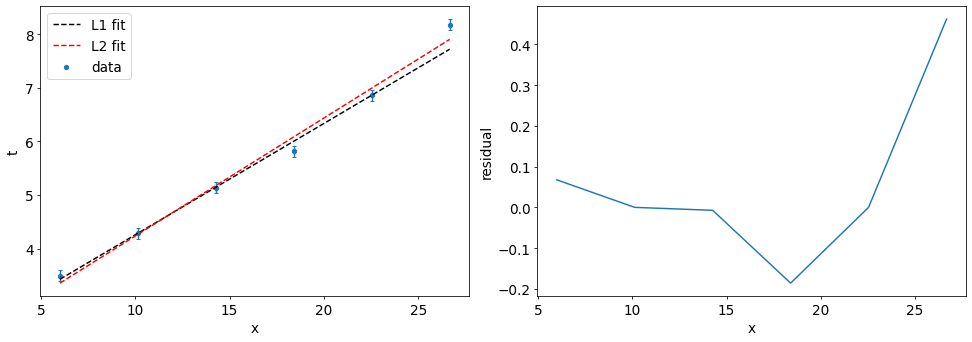

In [14]:
#-- plotting the data with model prediction ---
plt.figure(figsize=(14,5), dpi=70)

plt.subplot(121)
plt.scatter(data[:,0], data[:,1], label='data', s=20)
plt.errorbar(data[:,0], data[:,1], yerr = sigma, capsize=2, ls='None')
plt.plot(data[:,0], model_L1, ls='--', c='k', label='L1 fit')
plt.plot(data[:,0], model_L2, ls='--', c='r', label='L2 fit')
plt.xlabel('x', fontsize=14)
plt.ylabel('t', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc=2, fontsize=14)

plt.subplot(122)
plt.plot(data[:,0], L1_residual)
plt.xlabel('x', fontsize=14)
plt.ylabel('residual', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()


#### Part (h)

Monte Carlo error propagation

In [15]:
seed = 0
np.random.seed(seed)

nRealzns = 1000
noise_realzns = np.random.randn(data.shape[0], nRealzns)
data_realzns = np.zeros((data.shape[0], nRealzns))

#-- making different data realizations --
for i in range(nRealzns):
    
    data_realzns[:,i] = model_L1 + noise_realzns[:,i] 

A = np.zeros((nRealzns, nParams))

for i in range(nRealzns):
    
    mL1_temp = getL1Sol(data_realzns[:,i], G, L1_solution, tol)
    A[i,:] = mL1_temp - L1_solution

#-- covariance matric --
CovMat = np.matmul(A.T, A)/nRealzns

print('Covariance matrix')
print(CovMat)
print('\n')
print('L1 solution with 95% CI')
print(r't_0: {} +- {}'.format(L1_solution[0], 1.96*np.sqrt(np.diag(CovMat)[0])))
print(r's_2: {} +- {}'.format(L1_solution[1], 1.96*np.sqrt(np.diag(CovMat)[1])))


Covariance matrix
[[ 1.51926096 -0.07906165]
 [-0.07906165  0.00489036]]


L1 solution with 95% CI
t_0: 2.178635962094999 +- 2.4158627695978545
s_2: 0.2078951612904837 +- 0.13706497599288286


#### Part (i)

As discussed earlier, it is clear that the last data point (red circle in the figure below) is the outlier. 

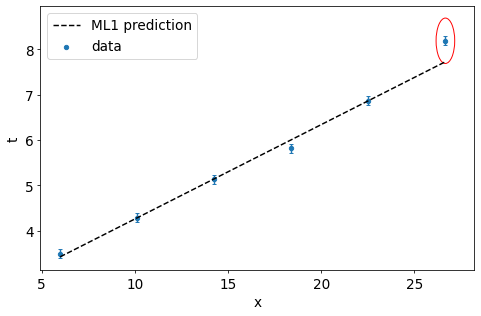

In [16]:
plt.figure(figsize=(8,5), dpi=70)
plt.scatter(data[:,0], data[:,1], label='data', s=20)
plt.errorbar(data[:,0], data[:,1], yerr = sigma, capsize=2, ls='None')
plt.plot(data[:,0], model_L1, ls='--', c='k', label='ML1 prediction')
circle = plt.Circle((data[-1,0], data[-1,1]), 0.5, color='r', fill=False)
plt.gca().add_patch(circle)
plt.xlabel('x', fontsize=14)
plt.ylabel('t', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc=2, fontsize=14)
plt.show()

### Q. 2.7.3

$\boldsymbol{d} = a + b\boldsymbol{x} + \eta \newline$
$\boldsymbol{x} = [1, 2, 3, 4, 5]^T \newline$
$a = b = 1\newline$
$\boldsymbol{\eta} \sim \mathcal{N}(0, 1)$

In [17]:
seed = 0
np.random.seed(seed)

nRealzns = 10000
nObs = 5
a_true, b_true = 1, 1
nParams = 2

noise_nRealzns = np.random.randn(nObs, nRealzns)
x = np.array([1, 2, 3, 4, 5])
data_realzns = np.zeros((nObs, nRealzns))

#-- making different data realizations --
for i in range(nRealzns):
    
    data_realzns[:,i] = a_true + b_true*x + noise_nRealzns[:,i] 

#### Part (a)
Least square solutions for $10000$ noisy data realizations

In [18]:
#-- model matrix ---
G = np.ones((nObs, nParams))
G[:,1] = G[:,1] * x

L2_solutions = []

for i in range(nRealzns):
    
    L2_solutions.append(getL2Sol(data_realzns[:,i], G))
    
L2_solutions = np.array(L2_solutions)

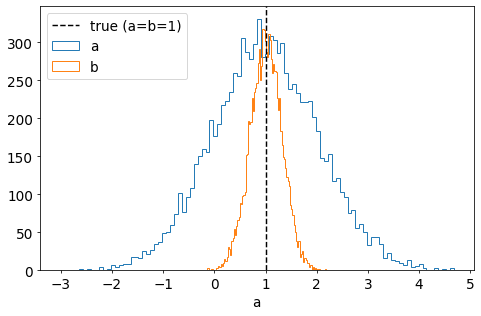

In [19]:
plt.figure(figsize=(8,5), dpi=70)

plt.hist(L2_solutions[:,0], bins=100, histtype='step', \
                                     label='a')
plt.hist(L2_solutions[:,1], bins=100, histtype='step', \
                                     label='b')
plt.axvline(x=a_true, ls='--', c='k', label='true (a=b=1)')
plt.xlabel('a', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

#### Part (b)
Covariance matrix
$\newline \boldsymbol{C} = \sigma^2 \, (G^TG)^{-1}$

In [20]:
#-- covariance matrix and variance array --
CovMat = sigma**2 * np.linalg.inv(np.matmul(np.transpose(G), G))

print('Covariance matrix')
print(CovMat)

print('sigma_a: {}'.format(CovMat[0,0]))
print('sigma_b: {}'.format(CovMat[1,1]))

Covariance matrix
[[ 0.011 -0.003]
 [-0.003  0.001]]
sigma_a: 0.011000000000000008
sigma_b: 0.0010000000000000005


#### Part (c)
Standardized parameter estimates

$\newline a^{'} = \frac{a-1}{\sqrt{C_{1,1}}}$
$\newline b^{'} = \frac{b-1}{\sqrt{C_{2,2}}}$

In [21]:
seed = 0
np.random.seed(seed)
std_normal_data = np.random.randn(nRealzns)

a_prime = np.zeros(nRealzns)
b_prime = np.zeros(nRealzns)

for i in range(nRealzns):
    
    a_prime[i] = (L2_solutions[i,0] - 1)/np.sqrt(CovMat[0,0])
    b_prime[i] = (L2_solutions[i,1] - 1)/np.sqrt(CovMat[1,1])

#-- mean of the data ---
a_prime_mean = np.mean(a_prime)
b_prime_mean = np.mean(b_prime)

#-- standard deviation of the data ---
a_prime_std = np.std(a_prime)
b_prime_std = np.std(b_prime)

#-- standardize the data ---
a_prime_stdzd = np.zeros(nRealzns)
b_prime_stdzd = np.zeros(nRealzns)

for i in range(nRealzns):
    a_prime_stdzd[i] = (a_prime[i]- a_prime_mean)/a_prime_std
    b_prime_stdzd[i] = (b_prime[i]- b_prime_mean)/b_prime_std

#-- calculation of quantiles from standard normal data --
vals = []
for i in range(nRealzns):
    temp = np.quantile(std_normal_data, i/nRealzns)
    vals.append(temp)

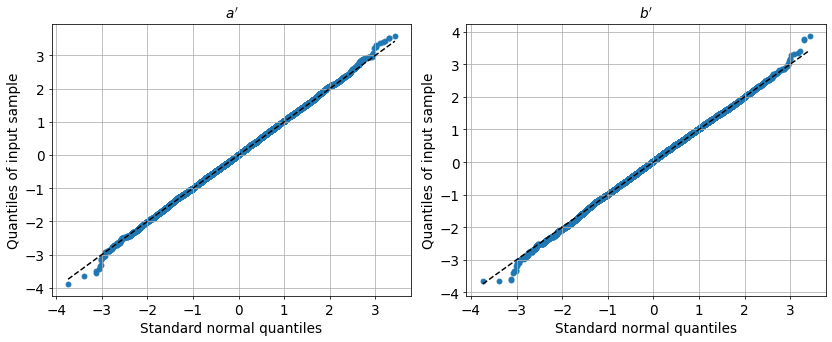

In [22]:
plt.subplots(figsize=(12, 5), dpi=70)

plt.subplot(121)
plt.scatter(vals, np.sort(a_prime_stdzd), marker='o', s=25)
plt.plot(vals, vals, ls='--', c='k')
plt.xlabel('Standard normal quantiles', fontsize=14)
plt.ylabel('Quantiles of input sample', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(r'$a^{\prime}$', fontsize=14)
plt.grid()

plt.subplot(122)
plt.scatter(vals, np.sort(b_prime_stdzd), marker='o', s=25)
plt.plot(vals, vals, ls='--', c='k')
plt.xlabel('Standard normal quantiles', fontsize=14)
plt.ylabel('Quantiles of input sample', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(r'$b^{\prime}$', fontsize=14)
plt.grid()

plt.tight_layout()
plt.show()

The above Q-Q plot shows that the estimates for $a^{'}$ and $b^{'}$ are distributed as $\mathcal{N}(0,1)$.

#### Part (d)

In [23]:
residualSq = np.zeros(nRealzns)

for i in range(nRealzns):
    
    residualSq[i] = np.sum(getResidual(data_realzns[:,i], L2_solutions[i,:])**2)

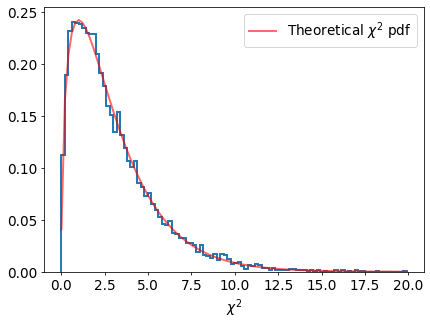

In [24]:
plt.subplots(figsize=(7, 5), dpi=70)

_, bins, _ = plt.hist(residualSq, bins=100, lw=2, histtype='step', density=True)
plt.plot(bins, chi2.pdf(bins, nObs-nParams),
               'r-', lw=2, alpha=0.6, label=r'Theoretical $\chi^2$ pdf')
plt.xlabel(r'$\chi^2$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

#### Part (e)
Estimation of noise standard deviation for each data realization

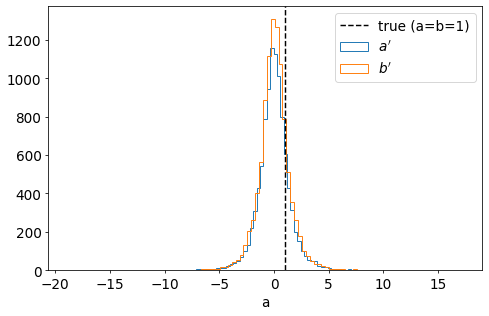

In [25]:
sigma_realzns = np.zeros(nRealzns)

for i in range(nRealzns):
    
    sigma_realzns[i] = np.sqrt(np.sum(getResidual(data_realzns[:,i], L2_solutions[i,:])**2) / (nObs-nParams))

#-- covariance matrix for each realization --
CovMat = []

for i in range(nRealzns):
    
    CovMat.append(sigma_realzns[i]**2 * np.linalg.inv(np.matmul(np.transpose(G), G)))

CovMat = np.array(CovMat)

seed = 0
np.random.seed(seed)
std_normal_data = np.random.randn(nRealzns)

a_prime = np.zeros(nRealzns)
b_prime = np.zeros(nRealzns)

for i in range(nRealzns):
    
    a_prime[i] = (L2_solutions[i,0] - 1)/np.sqrt(CovMat[i][0,0])
    b_prime[i] = (L2_solutions[i,1] - 1)/np.sqrt(CovMat[i][1,1])

#-- mean of the data ---
a_prime_mean = np.mean(a_prime)
b_prime_mean = np.mean(b_prime)

#-- standard deviation of the data ---
a_prime_std = np.std(a_prime)
b_prime_std = np.std(b_prime)

#-- standardize the data ---
a_prime_stdzd = np.zeros(nRealzns)
b_prime_stdzd = np.zeros(nRealzns)

for i in range(nRealzns):
    a_prime_stdzd[i] = (a_prime[i]- a_prime_mean)/a_prime_std
    b_prime_stdzd[i] = (b_prime[i]- b_prime_mean)/b_prime_std

#-- calculation of quantiles from standard normal data --
vals = []
for i in range(nRealzns):
    temp = np.quantile(std_normal_data, i/nRealzns)
    vals.append(temp)
    
plt.figure(figsize=(8,5), dpi=70)

plt.hist(a_prime, bins=100, histtype='step', \
                                     label=r'$a^{\prime}$')
plt.hist(b_prime, bins=100, histtype='step', \
                                     label=r'$b^{\prime}$')
plt.axvline(x=a_true, ls='--', c='k', label='true (a=b=1)')
plt.xlabel('a', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

#### Part (f)
Distribution of $a^{\prime}$ and $b^{\prime}$ for estimated standard deviation model

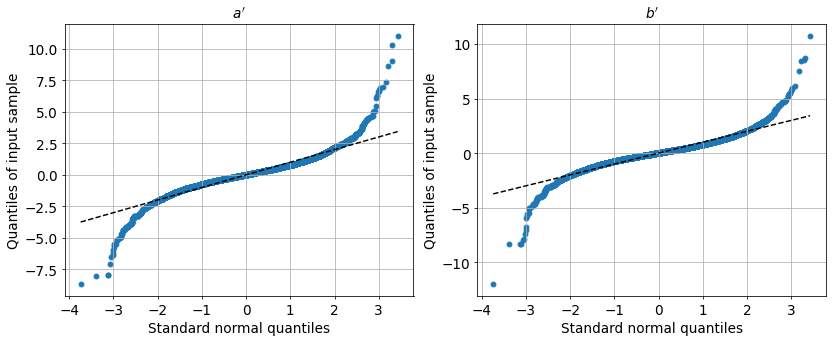

In [26]:
plt.subplots(figsize=(12, 5), dpi=70)

plt.subplot(121)
plt.scatter(vals, np.sort(a_prime_stdzd), marker='o', s=25)
plt.plot(vals, vals, ls='--', c='k')
plt.xlabel('Standard normal quantiles', fontsize=14)
plt.ylabel('Quantiles of input sample', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(r'$a^{\prime}$', fontsize=14)
plt.grid()

plt.subplot(122)
plt.scatter(vals, np.sort(b_prime_stdzd), marker='o', s=25)
plt.plot(vals, vals, ls='--', c='k')
plt.xlabel('Standard normal quantiles', fontsize=14)
plt.ylabel('Quantiles of input sample', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title(r'$b^{\prime}$', fontsize=14)
plt.grid()

plt.tight_layout()
plt.show()

### Q. 2.7.4


In [27]:
mean, sigma = 0, 8  # normal data errors

#-- data (first and second column represent time and position respectively ---
data = np.array([[1, 109.4], [2, 187.5], [3, 267.5], [4, 331.9], [5, 386.1], [6, 428.4], \
             [7, 452.2], [8, 498.1], [9, 512.3], [10, 513.0]]) 

nParams = 3  # no. of parameters
nObs = data.shape[0] # no. of observations

#-- model matrix ---
G = np.ones((nObs, 3))
G[:,1] = G[:,1] * data[:,0]
G[:,2] = - G[:,2] * data[:,0]**2 / 2

#-- L2 Solution ---
L2_solution = getL2Sol(data[:,1], G)

#-- model prediction with L2 solution ---
model_L2 = L2_solution[0] + L2_solution[1]*data[:,0] \
                                - 0.5 * L2_solution[2] * data[:,0]**2

#-- Generating data realizations ---
seed = 0
np.random.seed(seed)

nRealzns = 10000
nParams = 3

noise_nRealzns = sigma*np.random.randn(nObs, nRealzns)
data_realzns = np.zeros((nObs, nRealzns))

#-- making different data realizations --
for i in range(nRealzns):
    
    data_realzns[:,i] = model_L2 + noise_nRealzns[:,i] 

#-- Caculation of chisquare values and corresponding p-values ---
chisq_vals = np.zeros(nRealzns)
pvals = np.zeros(nRealzns)

for i in tqdm(range(nRealzns)):
    
    chisq_vals[i] = np.sum((data_realzns[:,i] - \
                            np.matmul(G, getL2Sol(data_realzns[:,i], \
                                    G).reshape(nParams,1)).flatten())**2 / sigma**2)
    
    pvals[i] = 1 - chi2(nObs-nParams).cdf(chisq_vals[i])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:06<00:00, 1577.13it/s]


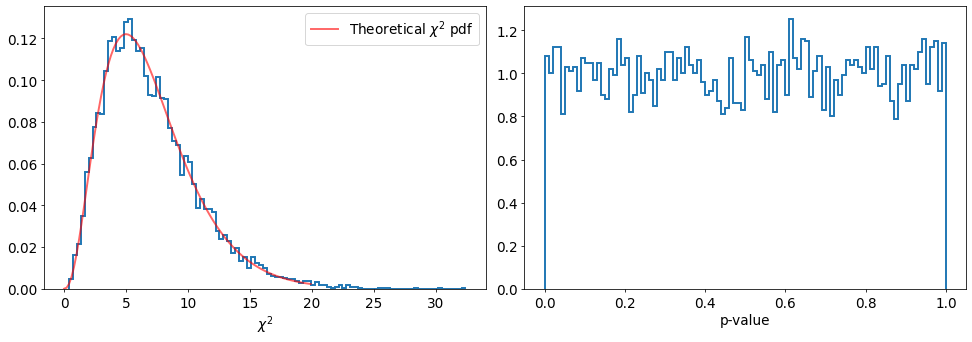

In [28]:
plt.figure(figsize=(14,5), dpi=70)

plt.subplot(121)
plt.hist(chisq_vals, bins=100, histtype='step', lw=2, density=True);
plt.plot(bins, chi2.pdf(bins, nObs-nParams),
               'r-', lw=2, alpha=0.6, label=r'Theoretical $\chi^2$ pdf')

plt.xlabel(r'$\chi^2$', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc=1, fontsize=14)

plt.subplot(122)
plt.hist(pvals, bins=100, histtype='step', lw=2, density=True);
plt.xlabel(r'p-value', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
plt.show()

#### Conclusion

The $\chi^2_{\text{obs}}$ values is distributed according to a $\chi^2$ distribution with $7$ degrees of freedom and the corresponding p-values is uniformly distributed 0 and 1.